##### Importing libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
import itertools


##### Creating the dataset that will be used, filtering the selected columns and adjusting the data type

In [75]:
df = pd.read_csv(
    "../datasets/lending_club.csv", 
    usecols=["loan_status", "total_acc", "int_rate", "revol_util", "annual_inc", "dti", "fico_range_low", "num_accts_ever_120_pd", "avg_cur_bal"]
)

df.rename(columns = {
    "loan_status": "credit_default", 
    "total_acc": "credit_card", 
    "int_rate": "interest_rate", 
    "revol_util": "utilization_rate", 
    "annual_inc": "income", 
    "dti": "debt_to_income", 
    "fico_range_low": "FICO_score", 
    "num_accts_ever_120_pd": "days_line", 
    "avg_cur_bal": "balance"
}, inplace = True)

df['credit_default'].replace({
    "Fully Paid": 0, 
    "Current": 0, 
    "Charged Off": 1
}, inplace=True)

df_filtered = df[df['credit_default'].isin([0, 1])]

df_filtered = df_filtered.dropna()

num_rows = len(df_filtered)

df_sample = df_filtered.sample(n=1000, random_state=42)
df_sample = df_sample[['credit_default', 'credit_card', 'interest_rate', 'utilization_rate', 'income', 'debt_to_income', 'FICO_score', 'days_line', 'balance']]

df_sample.head()


C:\Users\msala\AppData\Local\Temp\ipykernel_16148\3884252522.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['credit_default'].replace({


,credit_default,credit_card,interest_rate,utilization_rate,income,debt_to_income,FICO_score,days_line,balance
1548212,0,44.0,17.47,57.1,70000.0,16.24,670.0,0.0,25497.0
549538,0,46.0,16.02,66.2,110000.0,30.92,690.0,0.0,20145.0
1513102,0,29.0,12.13,71.9,81000.0,17.69,680.0,0.0,30390.0
39872,0,17.0,11.99,72.2,72000.0,21.83,675.0,0.0,4865.0
236286,0,39.0,14.65,41.0,38821.0,24.14,695.0,0.0,680.0


##### Separating the dataset into target column(y) and features(X)

In [76]:
X = df_sample[['credit_card', 'interest_rate', 'utilization_rate', 'income', 'debt_to_income', 'FICO_score', 'days_line', 'balance']]
y = df_sample['credit_default']

y = y.astype(int)

##### Creating dependency matrices between features and between the features and the target, using correlation as the dependency measure

In [77]:
corr_matrix = X.corr()

target_corr = df_sample.corr()['credit_default']
target_corr = target_corr.drop('credit_default')

##### Ploting the correlation matrix between features and between features and target

C:\Users\msala\AppData\Local\Temp\ipykernel_16148\770280867.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


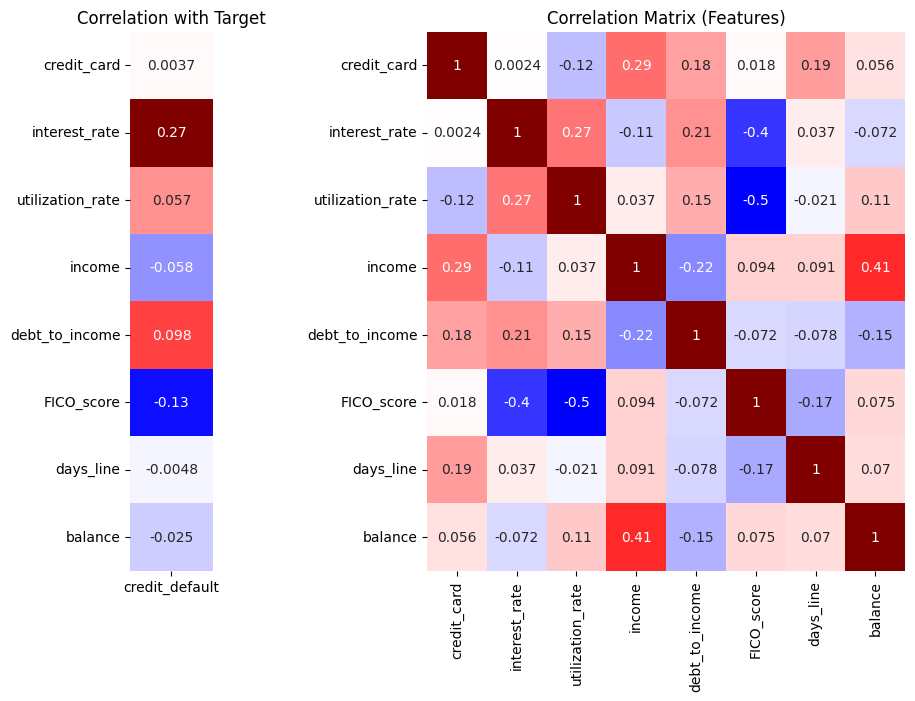

In [78]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 8, (4, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', cbar=False, ax=ax1, center=0)
ax1.set_title('Correlation Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 8, 1)
sns.heatmap(target_corr.to_frame(), annot=True, cmap='seismic', cbar=False, ax=ax2, center=0)
ax2.set_title('Correlation with Target', fontsize=12)

plt.tight_layout()

plt.show()

##### Creating dependency measures between features and between the features and the target, using Mutual Information as the dependency measure

In [79]:
def calculate_mi_matrix(X):
    n_features = X.shape[1]
    mi_matrix = pd.DataFrame(np.zeros((n_features, n_features)), index=X.columns, columns=X.columns)
    for i in range(n_features):
        for j in range(n_features):
            if i == j:
                mi_matrix.iloc[i, j] = 1
            else:
                mi_matrix.iloc[i, j] = mutual_info_regression(X.iloc[:, i].values.reshape(-1, 1), X.iloc[:, j])
    return mi_matrix

mi_matrix = calculate_mi_matrix(X)

mi_scores = mutual_info_classif(X, y, discrete_features=False)
target_mi = pd.Series(mi_scores, index=X.columns)
target_mi = target_mi.to_frame().rename(columns={0: 'credit_default'})

##### Ploting Mutual Information matrix between features and between features and target

C:\Users\msala\AppData\Local\Temp\ipykernel_16148\4207534654.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


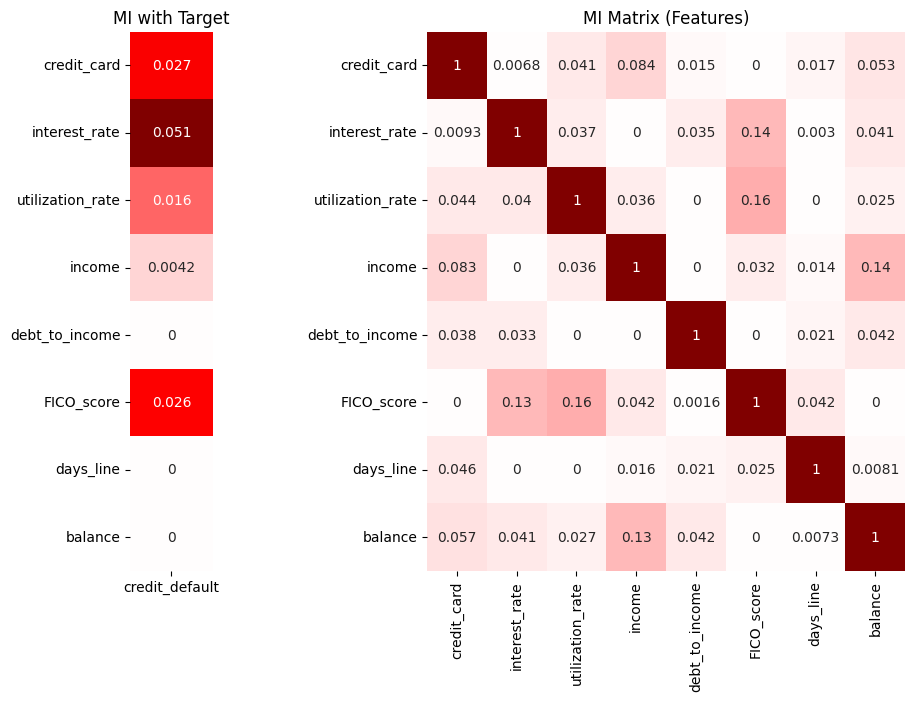

In [80]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 8, (4, 8))
sns.heatmap(mi_matrix, annot=True, cmap='seismic', cbar=False, ax=ax1, center=0)
ax1.set_title('MI Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 8, 1)
sns.heatmap(target_mi, annot=True, cmap='seismic', cbar=False, ax=ax2, center=0)
ax2.set_title('MI with Target', fontsize=12)

plt.tight_layout()

plt.show()

##### Creating dependency measures between the features and the target using AUC ROC as the dependency measure

In [81]:
roc_scores = []
for feature in X.columns:
    try:
        roc = roc_auc_score(y, X[feature])
        roc_scores.append(roc)
    except ValueError:
        roc_scores.append(np.nan)

target_roc = pd.Series(roc_scores, index=X.columns)
target_roc = target_roc.to_frame().rename(columns={0: 'credit_default'})

##### Ploting the AUC ROC values between the features and the target

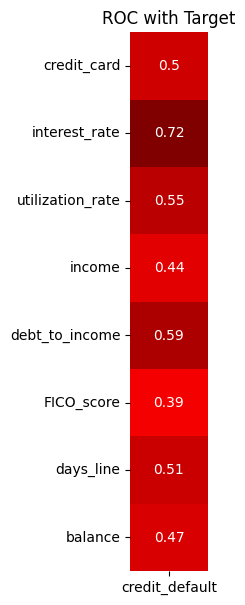

In [82]:
plt.figure(figsize=(1, 7))

sns.heatmap(target_roc, annot=True, cmap='seismic', cbar=False, center=0)
plt.title('ROC with Target', fontsize=12)

plt.show()

##### Selecting the model(Logist Regression) and separating the data between train and test datasets

In [83]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Defining a list for the Brute Force Algorithm, acting as an matrix with arrays denoting which features are beeing used

In [84]:
combinations = list(itertools.product([0, 1], repeat=8))

combinations = np.array(combinations)
combinations = combinations[1:]

mask = np.sum(combinations, axis=1) != 1
combinations = combinations[mask]

##### Auxiliary functions to sum the dependencies between features and target(sumFeatureTarget) and between features(sumFeatureFeature)

In [85]:
def sumFeatureTarget(z, array):
    total = 0
    for i in range(len(z)):
        total += z[i] * abs(float(array.iloc[i]))

    return total

def sumFeatureFeature(z, matrix):
    total = 0
    for i in range(len(z)):
        for j in range(len(z)):
            if i != j:
                total += z[i] * z[j] * abs(float(matrix.iloc[i, j]))

    return total

##### Brute Force Algorithm

In [86]:
def brute_force(phi, combinations, array, matrix):
    min = 10000
    features = []
    for combination in combinations:
        h = -((phi * sumFeatureTarget(combination, array)) - ((1 - phi) * sumFeatureFeature(combination, matrix)))
        if h < min:
            min = h
            features = combination

    features = [i for i, val in enumerate(features) if val == 1]
    return features

##### Training and evaluating the model, and returning the Area Under the ROC

In [87]:
def train_and_evaluate(X_train, y_train, X_test, y_test, features):
    X_train_subset = X_train.iloc[:, features]
    X_test_subset = X_test.iloc[:, features]

    model.fit(X_train_subset, y_train)
    
    predictions = model.predict_proba(X_test_subset)[:, 1]
     
    auroc = roc_auc_score(y_test, predictions)
    return auroc


##### Applying the the Brute Force Algorithm for different values of Phi, varying from 0 to 1

In [88]:
x_roc_correl = []
x_roc_mi = []
y_axis = []

for phi in np.arange(0, 1.1, 0.1):
    selected_features_roc_corr = brute_force(phi, combinations, target_roc, corr_matrix) # Using ROC and Correlation
    selected_features_roc_mi = brute_force(phi, combinations, target_roc, mi_matrix) # Using ROC and Mutual Information

    auroc_roc_corr = train_and_evaluate(X_train, y_train, X_test, y_test, selected_features_roc_corr)
    auroc_roc_mi = train_and_evaluate(X_train, y_train, X_test, y_test, selected_features_roc_mi)

    x_roc_correl.append(auroc_roc_corr)
    x_roc_mi.append(auroc_roc_mi)
    y_axis.append(phi)

C:\Users\msala\AppData\Local\Temp\ipykernel_16148\4244708241.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  total += z[i] * abs(float(array.iloc[i]))
C:\Users\msala\AppData\Local\Temp\ipykernel_16148\4244708241.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  total += z[i] * abs(float(array.iloc[i]))
d:\Faculdade\ICquantica\Quantum-Computer-Feature-Selection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

##### Ploting the graph with the results

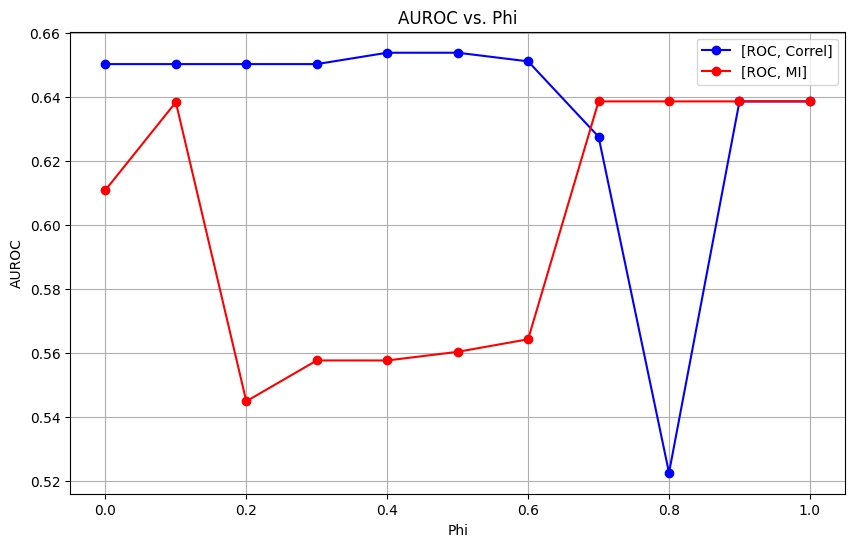

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(y_axis, x_roc_correl, marker='o', linestyle='-', color='b', label='[ROC, Correl]')
plt.plot(y_axis, x_roc_mi, marker='o', linestyle='-', color='r', label='[ROC, MI]')

plt.title('AUROC vs. Phi')
plt.xlabel('Phi')
plt.ylabel('AUROC')
plt.legend()

plt.grid(True)
plt.show()